<h1><center> Model to predict SIT error at a local point </center></h1>

Goal: predict the error at a specific point.

In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import subprocess
from keras.regularizers import L1L2
import netCDF4 as nc4
import random

from src.data_preparation import mdl_dataset
from src.data_preparation import load_data

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

from src.modelling import model_cnn
from src.modelling import model_lstm
# from src.modelling import super_model_dl

from src.visualization import visualize_pca
from src.visualization import mdl_introspect
from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils
from src.utils import save_name

2023-01-20 10:18:51.753600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 10:18:51.753664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Config

In [2]:
# file_config = '../config/data_proc_full.yaml'

In [3]:
# file_config = '../config/config_to_jobs/config_CNN_no_bias_0wk.yaml'
file_config = '../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml'

In [4]:
rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/lstm
Folder created

Subfolder created: /nird/projects/nird/NS2993K/Leo/results/lstm/ml/
Subfolder created: /nird/projects/nird/NS2993K/Leo/results/lstm/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Config folders updated.
Config copied to: /nird/projects/nird/NS2993K/Leo/results/lstm
Config file found: /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Default config file is now the copied following one:
/nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml


# Cluster 

In [5]:
def plot_1cluster(n, km, points=[], savefig=False, showfig=True, odir=''):
    """ Plot a given cluster [0-max] on a map
    
    Parameters:
    -----------
        n       : int, number of the cluster to draw
        km      : K mean, DataArray 2D (y,x) containing Kmean groups
        points  : list of (y,x) points to draw on the map
    
    """
    fig, ax = plt.subplots(figsize=(19,12))

    km.where(km == -999).plot(ax=ax, cmap=plt.cm.Greys, add_colorbar=False)
    km.where(km > -1).plot(ax=ax, vmin=-2, vmax=-2, cmap=plt.cm.Blues, add_colorbar=False)
    km.where(km == n).plot(ax=ax, add_colorbar=False, cmap=plt.cm.Reds)

    nb_pts = np.count_nonzero(np.array(km) == n)
    plt.title(f'Cluster {n}: {nb_pts}')
    

    if len(points):
        markers = ['+'] + ['.'] * int(len(points)-1)
        for idx, point in enumerate(points):
            ax.scatter(km.x.data[point[1]], km.y.data[point[0]], marker=markers[idx], color='#4BD6F1', 
                    s=800, linewidths=6)
    
    if savefig:
        ofile = f'Kmean_cluster{n}.png'
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}")
        print(f'Saved as: {odir}{ofile}')

    if showfig:
        plt.show()


    plt.close()

In [6]:
def sel_rdn_pt(km, cluster_sel):
    '''Selection a random point of a defined cluster (or average over a Kmean group)
    Parameters:
    -----------
    
        km         : K mean, DataArray 2D (y,x) containing Kmean groups
        cluser_sel : int, cluster in which to select a point. from 0 to n_clusters
    
    '''
    # cluster_sel = 6
    points_cl = np.where(km==cluster_sel)

    rdn = random.randint(0, len(points_cl[0]))
    idx_pt = points_cl[0][rdn], points_cl[1][rdn]  # (y, x)

    print(f'Point {rdn} of cluster {cluster_sel}: {idx_pt}')
    return idx_pt

In [7]:
# import Kmean group results

n_clusters = 10

idir = '/nird/projects/nird/NS2993K/Leo/results/xgb_230118-135014/ml/'
ifile = f'Kmean_n{n_clusters}_2011_2019.nc'


nc = nc4.Dataset(f'{idir}{ifile}', mode='r')
km = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['km']
corr = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['corr']


In [54]:
# Selection a random point of a defined cluster (or average over a Kmean group)
cluster_sel = 6
idx_pt = sel_rdn_pt(km, cluster_sel=cluster_sel)

Point 3499 of cluster 6: (230, 82)


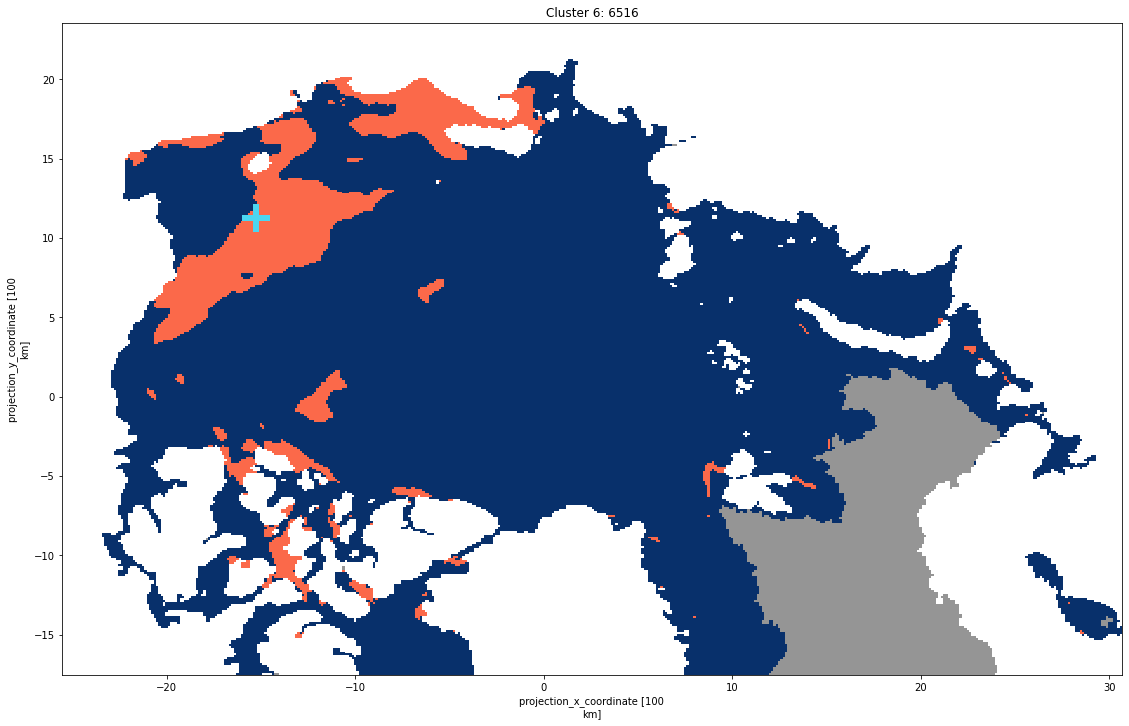

In [55]:
# visualize random point
plot_1cluster(cluster_sel, km, points=[idx_pt])

# -----------------------------------------

# Loading Dataset

In [10]:
# setup='no_bias'
# conf.setup

ds = mdl_dataset.Dataset(conf, setup='no_bias', objective='local_train', point=idx_pt) # var_to_keep=var_to_keep, 

# Xeg, chrono, Xna, covar, forcings, maskok = load_data.load_dataset_g2l(conf)



Initialisation dataset...
History loaded from config file: /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Size of the training set:    1950 days
Size of the validation set:   450 days
Size of the test set:         600 days
Config file updated 'ntrain': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3000, 13) to (3000, 13) for H=[0].


In [11]:
ds.dataset

{'X': array([[0.24261883, 0.68055241, 0.27227079, ..., 0.86421525, 0.71670582,
         0.38170331],
        [0.24261136, 0.66856981, 0.29625614, ..., 0.85812117, 0.71745133,
         0.38199057],
        [0.24417509, 0.65370376, 0.31917565, ..., 0.90242054, 0.72199647,
         0.38716606],
        ...,
        [0.29694573, 0.24723371, 0.26967593, ..., 0.22179382, 0.71628328,
         0.38470563],
        [0.29983723, 0.24499348, 0.25743062, ..., 0.33007331, 0.71289978,
         0.38592991],
        [0.30231688, 0.24275101, 0.26061761, ..., 0.40054464, 0.71633375,
         0.38483947]]),
 'y': array([[ 0.60974944],
        [ 0.63981016],
        [ 0.65781546],
        ...,
        [-0.09953983],
        [-0.09735563],
        [-0.09115387]]),
 'chrono':            date
 0    2011-10-01
 1    2011-10-02
 2    2011-10-03
 3    2011-10-04
 4    2011-10-05
 ...         ...
 2995 2019-12-13
 2996 2019-12-14
 2997 2019-12-15
 2998 2019-12-16
 2999 2019-12-17
 
 [3000 rows x 1 columns],
 'nt

In [58]:
# to change point used WITHOUT RELOADING ALL DATASET:
#new_point = sel_rdn_pt(km, 6)
ds.redefine_point(idx_pt)  # new_point)

Size of the training set:    1950 days
Size of the validation set:   450 days
Size of the test set:         600 days
Config file updated 'ntrain': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3000, 13) to (2978, 4, 13) for H=[1, 8, 15, 22].


# ---------------

## Fromatting dataset

In [13]:
if 'CNN' in ds.config.ml_name:
    ds.history.params['keras']['H'] = [0,7,14,21,28, 35, 42, 49, 56, 63, 70, 77]
    ds.format_for_dl(ml_model='cnn')
    
elif 'LSTM' in ds.config.ml_name:
    ds.history.params['keras']['H'] = [1,8,15,22]
    ds.format_for_dl(ml_model='lstm')

Dataset Format for lstm
Dataset formatted from (3000, 13) to (2978, 4, 13) for H=[1, 8, 15, 22].


# Run model

In [41]:
from importlib import reload

In [92]:
from src.modelling import super_model_dl

In [191]:
reload(model_lstm)

<module 'src.modelling.model_lstm' from '/cluster/home/leoede/tardis/tardis-ml/src/modelling/model_lstm.py'>

In [192]:
reload(super_model_dl)

<module 'src.modelling.super_model_dl' from '/cluster/home/leoede/tardis/tardis-ml/src/modelling/super_model_dl.py'>

In [193]:
# ---------------------------------------------------
#                 Building cnn
# ---------------------------------------------------

suffixe = ''  # useless ?
# reg = regularizers[0]
n_components = 1 # local model
    

In [194]:
if 'CNN' in ds.config.ml_name:
    m4 = model_cnn.ModelCNN(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                        rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                        fig_dir=ds.config.fig_dir)

elif 'LSTM' in ds.config.ml_name:
    m4 = model_lstm.ModelLSTM(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                        rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                        fig_dir=ds.config.fig_dir)

In [195]:
ds.dataset['Xtrain'].shape

(1935, 4, 13)

# .--------------------------------------------------------

In [83]:
import tensorflow as tf
import tensorflow_addons as tfa

In [76]:
from keras.layers import Input, LSTM, Dense, Bidirectional, Attention
from keras.models import Model

In [86]:
def mdl_LSTM_at(timesteps, features):
    '''2 LSTM Layer, Bidirectional (explore dependencies in past and future) and 
    an attention layer (help model focus on most important parts ot the time series)
    '''
    
    # Define the input layer
    inputs = Input(shape=(timesteps, features)) # input_dim))

    # Define the LSTM layers
    lstm1 = LSTM(64, return_sequences=True)(inputs)
    lstm2 = LSTM(64, return_sequences=True)(lstm1)

    # Define the bidirectional layer
    bidirectional = Bidirectional(LSTM(32, return_sequences=True))(lstm2)

    # Define the attention layer
    attention = Attention()(bidirectional)

    # Define the output layer
    outputs = Dense(1)(attention)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error')
    opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=opt, loss='mse', metrics=[tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError()])


    print('Compiled !')
    return model

In [74]:
ds.dataset['X'].shape

(2978, 4, 13)

In [ ]:
m3.fit()

In [88]:
reload(model_lstm)

<module 'src.modelling.model_lstm' from '/cluster/home/leoede/tardis/tardis-ml/src/modelling/model_lstm.py'>

# .--------------------------------------------------------

In [196]:
m4.compile_models(npca=n_components, name='LSTM_at')

input change depending on model !!
Compiled !


In [197]:
m4.print_summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 4, 13)]      0           []                               
                                                                                                  
 lstm_36 (LSTM)                 (None, 4, 64)        19968       ['input_11[0][0]']               
                                                                                                  
 lstm_37 (LSTM)                 (None, 4, 64)        33024       ['lstm_36[0][0]']                
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 4, 64)       24832       ['lstm_37[0][0]']                
 l)                                                                                         

In [198]:
m4.fit_multiple(ds.dataset, suffix=suffixe) 

Fitting...
pc0 Training finished !


In [199]:
# m4.print_histories()
m4.predict_multiple(ds.dataset, ds.point)
# m4.save_prediction()
#m4.save_model()

94/94 [==============================] - 3s 3ms/step
Prediction finished !!


In [200]:
m4.ypred.shape

(2978, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


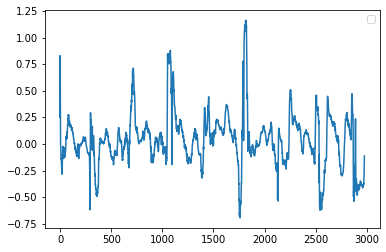

In [201]:
plt.plot(m4.ypred[:,0])
# plt.plot(ds.dataset['y'], label='ytrue')
plt.legend()

In [117]:
x = np.concatenate((ds.dataset["Xtest"], ds.dataset["Xval"], ds.dataset["Xtrain"]))


In [119]:
ypred = m4.models[f'pc{0}'].predict(x, verbose=1)

94/94 [==============================] - 0s 3ms/step


In [120]:
ypred.shape

(2978, 4, 1)

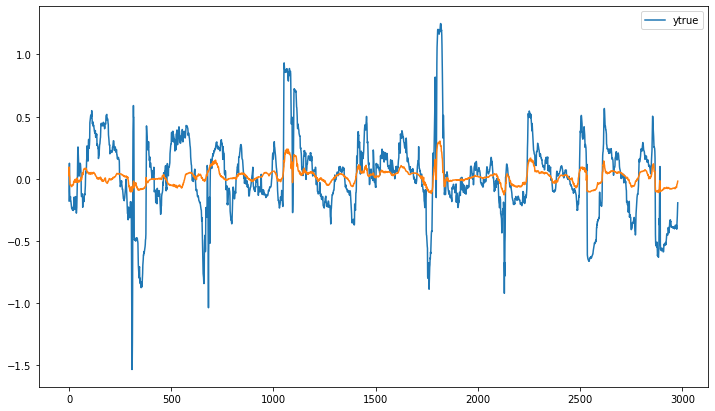

In [202]:
fig, ax = plt.subplots(figsize=(12,7))


plt.plot(ds.dataset['y'], label='ytrue')
plt.plot(ypred[:,0])
plt.legend()

In [130]:
ytrue = ds.dataset['y']

In [131]:
bias_t1 = ypred[:,0]-ytrue

In [132]:
bias_t2 = ypred[:,1]-ytrue

In [133]:
bias_t3 = ypred[:,2]-ytrue

In [134]:
bias_t4 = ypred[:,3]-ytrue

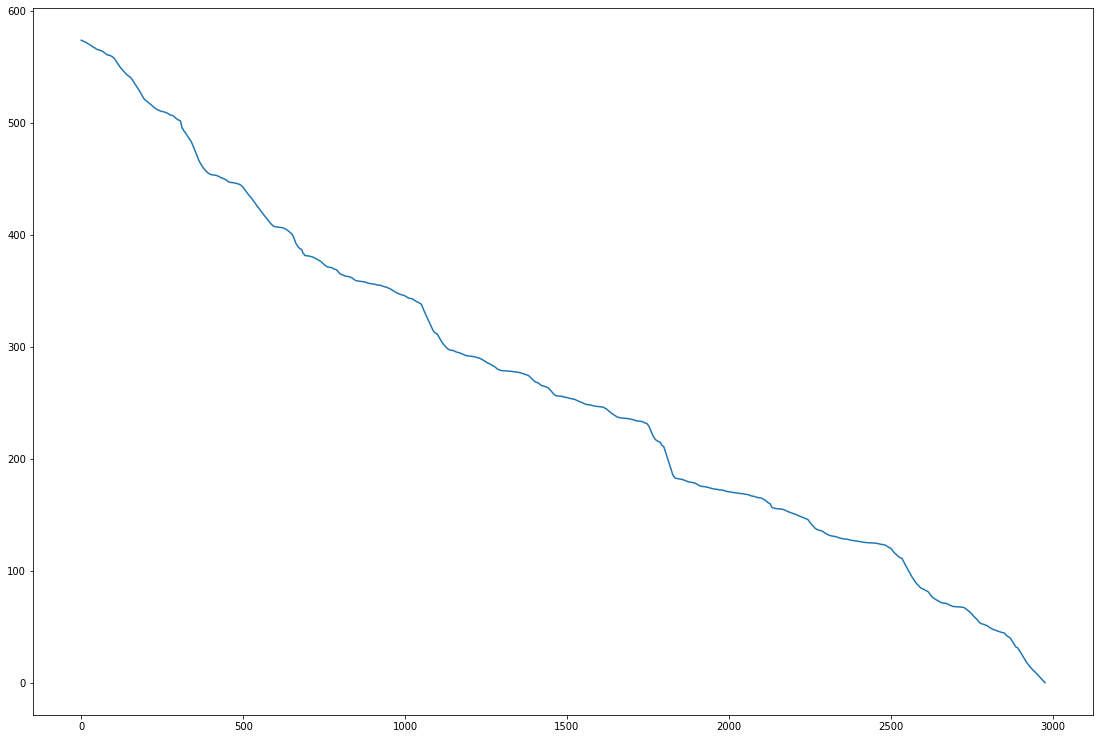

In [153]:
fig, ax = plt.subplots(figsize=(19,13))

plt.plot(np.cumsum(abs(bias_t1[::-1]))[::-1])
# plt.plot(bias_t2)
#plt.plot(bias_t3)
#plt.plot(bias_t4)

In [141]:
np.cumsum?

(2978, 1)

## Plot

Saved as: /nird/projects/nird/NS2993K/Leo/results/lstm/figures/LSTM_at_ypred.png


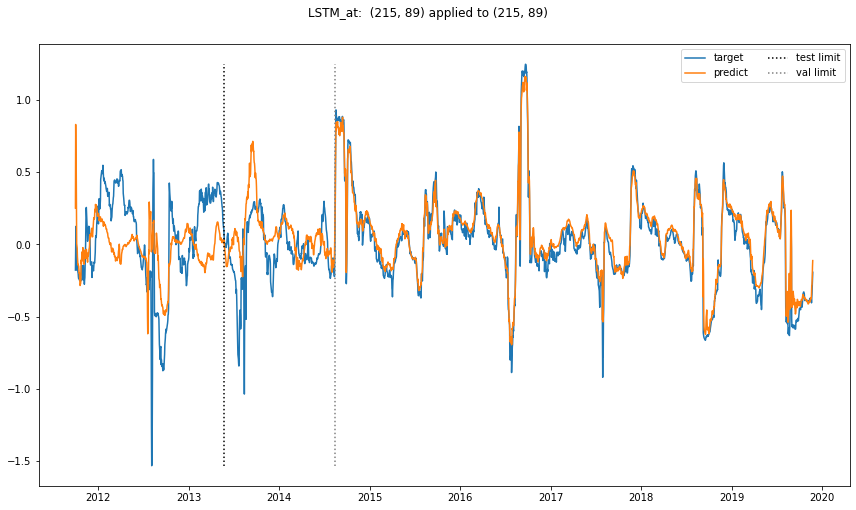

In [203]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True, ofile=ofile)

Saved as: /nird/projects/nird/NS2993K/Leo/results/lstm/figures/LSTM3_bk_ypred_04.png


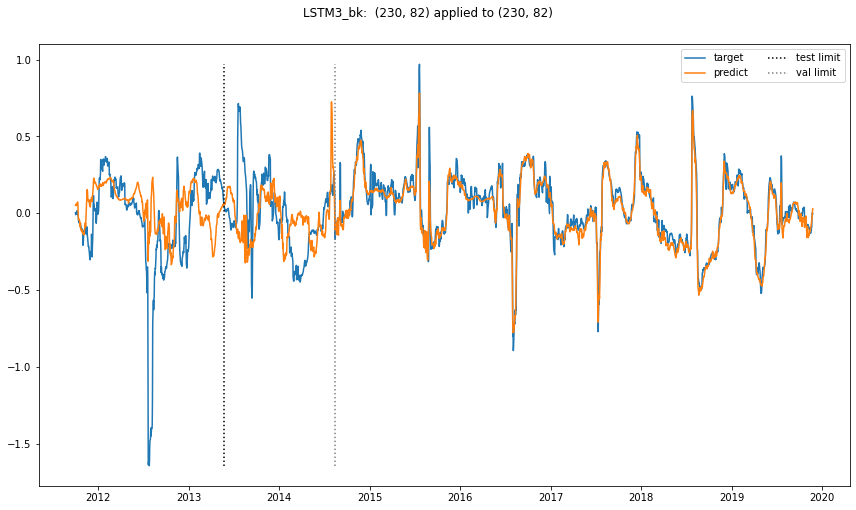

In [62]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True, ofile=ofile)

# Apply to another point

In [63]:
# to change point used:
new_point = sel_rdn_pt(km, 6)
ds.redefine_point(new_point)

Point 2870 of cluster 6: (215, 89)
Size of the training set:    1950 days
Size of the validation set:   450 days
Size of the test set:         600 days
Config file updated 'ntrain': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /nird/projects/nird/NS2993K/Leo/results/lstm/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3000, 13) to (2978, 4, 13) for H=[1, 8, 15, 22].


In [64]:
m4.predict_multiple(ds.dataset, ds.point)
m4.save_prediction()

94/94 [==============================] - 0s 2ms/step
Prediction finished !!
Save prediction as .nc
Ytrue saved as: /nird/projects/nird/NS2993K/Leo/results/lstm/ml/ypred_LSTM3_bk_05.nc


Saved as: /nird/projects/nird/NS2993K/Leo/results/lstm/figures/LSTM3_bk_ypred_05.png


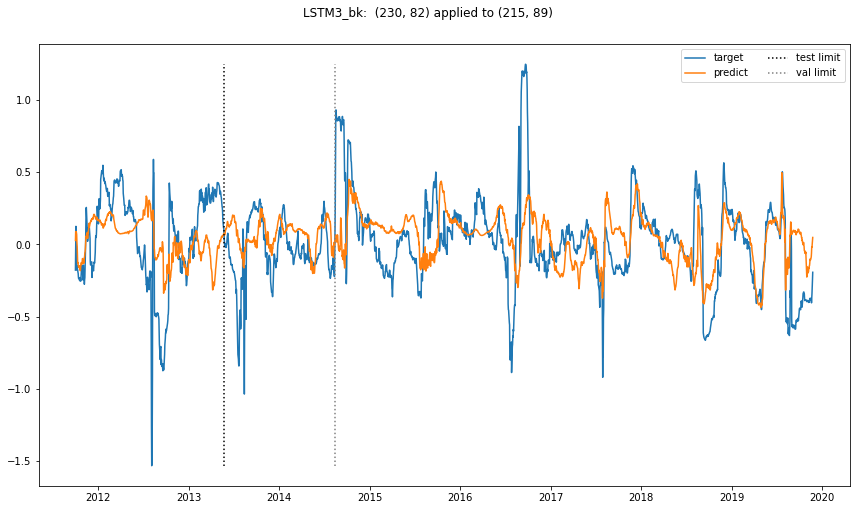

In [65]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True, ofile=ofile)

Saved as: /nird/projects/nird/NS2993K/Leo/results/lstm/figures/Kmean_cluster6_02.png


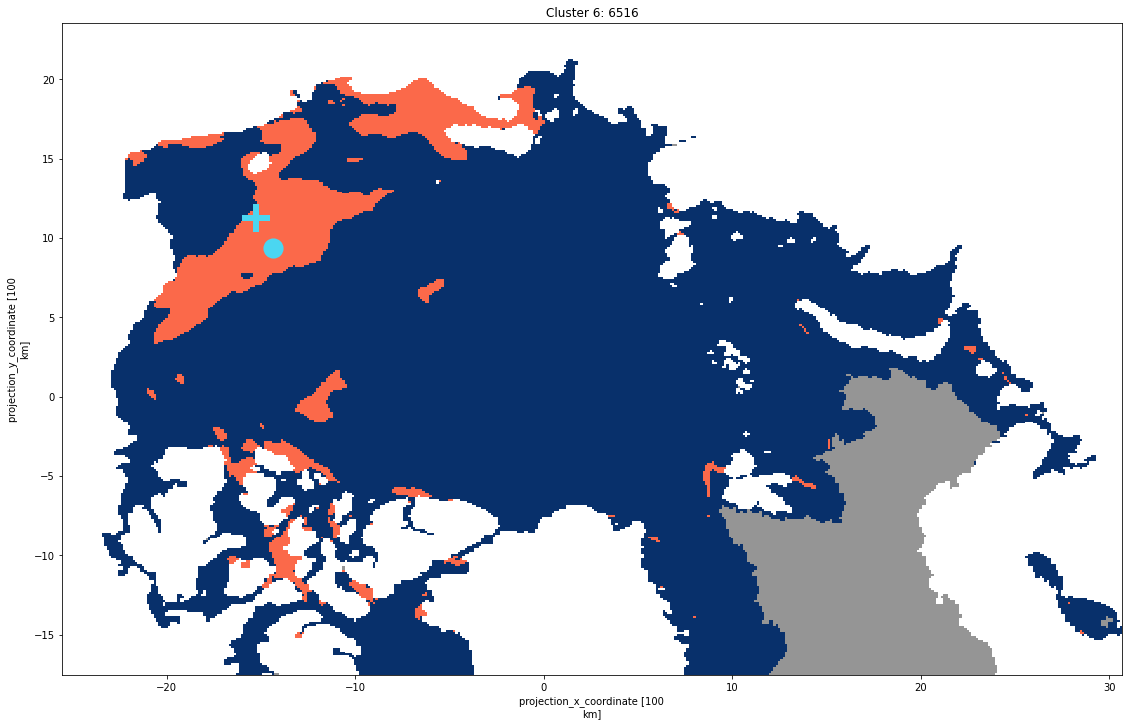

In [66]:
# visualize random point
plot_1cluster(cluster_sel, km, points=[idx_pt, new_point], odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True)

# Train with an average of the 8 surroundings points

# Train with an average of all the cluster

# Train LSTM + other architectures